# Part 1

import statements and loading in file

In [3]:
import pandas as pd
import numpy as np
from fancyimpute import KNN  # You can replace KNN with other methods in fancyimpute if needed
from sklearn.model_selection import train_test_split
from scipy.stats import zscore
import random
import matplotlib.pyplot as plt
import seaborn as sns

data = pd.read_csv('facteus_10k_user_panel.csv', parse_dates=['date'])

Pivot data and remove outliers

In [4]:
threshold = 10
zscore_threshold = 3
# Load the data (Leave commented out since we have data in memory already)
# data = pd.read_csv('drive/My Drive/facteus_10k_user_panel.zip', compression='zip', parse_dates=['date'])

# 1. Pivot data to user/month/total dollar spend
data['date'] = data['date'].dt.tz_localize(None)
data['month'] = data['date'].dt.to_period('M')
data_grouped = data.groupby(['account', 'month'])['spend'].sum()
pivot_data = data_grouped.unstack()
data_grouped = data_grouped.reset_index()
# data_grouped columns are ["account", "month", "spend"]

# Calculate the percentage of NaN values for each account
nan_percentage_by_account = pivot_data.isnull().sum(axis=1) / pivot_data.shape[1] * 100

# Remove accounts with more than 'threshold' % NaN values
filtered_pivot_data = pivot_data[nan_percentage_by_account <= threshold]

# Remove outliers at the user/month level using z-score on log(spend)
filtered_pivot_data_stacked = filtered_pivot_data.stack().reset_index()
filtered_pivot_data_stacked.columns = ['account', 'month', 'spend']
filtered_pivot_data_stacked['log_spend'] = np.log(filtered_pivot_data_stacked['spend'] + 1)  # Adding 1 to avoid log(0)
filtered_pivot_data_stacked['zscore'] = filtered_pivot_data_stacked.groupby('account')['log_spend'].transform(lambda x: zscore(x, nan_policy='omit'))
filtered_pivot_data_stacked = filtered_pivot_data_stacked[filtered_pivot_data_stacked['zscore'].abs() <= 3]

# Drop the zscore and log_spend columns as they are no longer needed
filtered_pivot_data_stacked = filtered_pivot_data_stacked.drop(columns=['zscore', 'log_spend'])

# Transform filtered_pivot_data_stacked back to have each row being an account and each month being a column
filtered_pivot_data = filtered_pivot_data_stacked.pivot(index='account', columns='month', values='spend')

Find probabilities and create a test set

In [5]:
# Calculate probabilities
# 1. Probability that if there is a spend value for a given month, the next month's spend value is missing
has_spend = filtered_pivot_data.notna()
missing_next_month = has_spend.shift(-1, axis=1).isna()
prob_spend_next_missing = (has_spend & missing_next_month).sum().sum() / has_spend.sum().sum()

# 2. Probability that if a spend value is missing for a given month, the next month's spend value is also missing
is_missing = filtered_pivot_data.isna()
missing_next_month_if_missing = is_missing.shift(-1, axis=1)
prob_missing_next_missing = (is_missing & missing_next_month_if_missing).sum().sum() / is_missing.sum().sum()

print(f"Probability that if there is a spend value for a given month, the next month's spend value is missing: {prob_spend_next_missing}")
print(f"Probability that if a spend value is missing for a given month, the next month's spend value is also missing: {prob_missing_next_missing}")

# Create a test set by removing data based on calculated probabilities
test_data = filtered_pivot_data.copy()
removed_values = []
for account in test_data.index:
    for month in test_data.columns[:-1]:  # Exclude the last month since there is no next month
        if pd.notna(test_data.at[account, month]):
            # Remove value with probability prob_spend_next_missing
            if random.random() < prob_spend_next_missing:
                test_data.at[account, month + 1] = np.nan
                removed_values.append((account, month + 1))
        elif pd.isna(test_data.at[account, month]):
            # Remove value with probability prob_missing_next_missing
            if random.random() < prob_missing_next_missing:
                test_data.at[account, month + 1] = np.nan
                removed_values.append((account, month + 1))

# Track removed values
removed_values_df = pd.DataFrame(removed_values, columns=['account', 'month'])

# Show percent of values in withholding set
print(f"{np.round(len(removed_values_df)/len(filtered_pivot_data_stacked), 3)} of the data is in the test set")
# The filtered data, test set, and probabilities are now ready for further analysis or modeling

Probability that if there is a spend value for a given month, the next month's spend value is missing: 0.026957562881474946
Probability that if a spend value is missing for a given month, the next month's spend value is also missing: 0.3286999182338512
0.053 of the data is in the test set


impute data

Imputing row 1/6443 with 0 missing, elapsed time: 11.129
Imputing row 101/6443 with 4 missing, elapsed time: 11.150
Imputing row 201/6443 with 4 missing, elapsed time: 11.163
Imputing row 301/6443 with 5 missing, elapsed time: 11.174
Imputing row 401/6443 with 2 missing, elapsed time: 11.192
Imputing row 501/6443 with 4 missing, elapsed time: 11.204
Imputing row 601/6443 with 4 missing, elapsed time: 11.216
Imputing row 701/6443 with 5 missing, elapsed time: 11.228
Imputing row 801/6443 with 2 missing, elapsed time: 11.241
Imputing row 901/6443 with 3 missing, elapsed time: 11.254
Imputing row 1001/6443 with 2 missing, elapsed time: 11.266
Imputing row 1101/6443 with 2 missing, elapsed time: 11.279
Imputing row 1201/6443 with 7 missing, elapsed time: 11.297
Imputing row 1301/6443 with 2 missing, elapsed time: 11.312
Imputing row 1401/6443 with 3 missing, elapsed time: 11.326
Imputing row 1501/6443 with 5 missing, elapsed time: 11.339
Imputing row 1601/6443 with 2 missing, elapsed time:

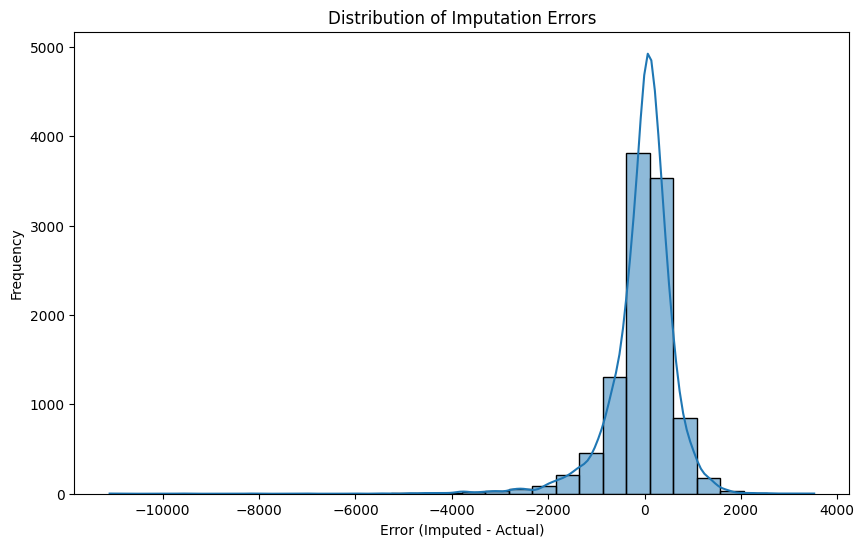

In [6]:
# Impute the missing data in test_data using KNN
knn_imputer = KNN()
imputed_data = knn_imputer.fit_transform(test_data)
imputed_data_df = pd.DataFrame(imputed_data, index=test_data.index, columns=test_data.columns)

# Compare imputed values with actual values
comparison_results = []
for account, month in removed_values:
    actual_value = filtered_pivot_data.at[account, month]
    imputed_value = imputed_data_df.at[account, month]
    comparison_results.append({'account': account, 'month': month, 'actual_value': actual_value, 'imputed_value': imputed_value})

comparison_df = pd.DataFrame(comparison_results).dropna(subset=['actual_value'])
comparison_df['error'] = comparison_df['imputed_value'] - comparison_df['actual_value']
comparison_df['absolute_error'] = comparison_df['error'].abs()

# Plotting the distribution of errors
plt.figure(figsize=(10, 6))
sns.histplot(comparison_df['error'], bins=30, kde=True)
plt.xlabel('Error (Imputed - Actual)')
plt.ylabel('Frequency')
plt.title('Distribution of Imputation Errors')
plt.show()

Graph the Cumulative Error Distribution

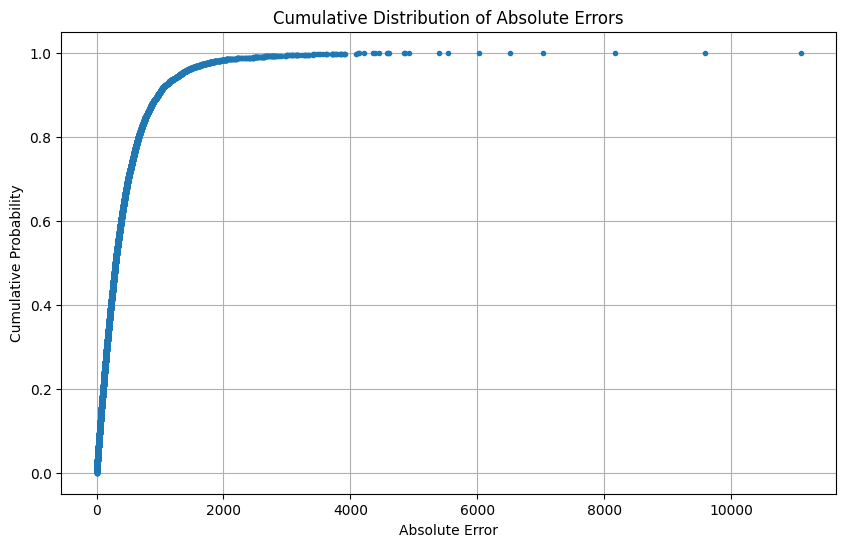

In [7]:
# Cumulative Error Distribution
plt.figure(figsize=(10, 6))
sorted_errors = np.sort(np.abs(comparison_df['error']))
cdf = np.arange(1, len(sorted_errors) + 1) / len(sorted_errors)
plt.plot(sorted_errors, cdf, marker='.', linestyle='none')
plt.xlabel('Absolute Error')
plt.ylabel('Cumulative Probability')
plt.title('Cumulative Distribution of Absolute Errors')
plt.grid()
plt.show()

Generate Boxplot

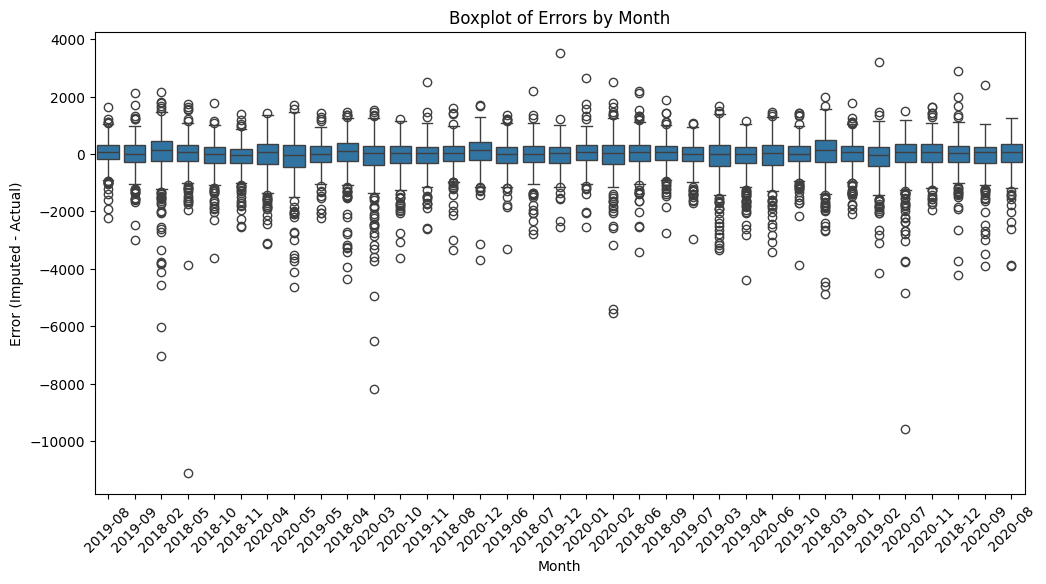

In [8]:
# Boxplot by Month
plt.figure(figsize=(12, 6))
sns.boxplot(x='month', y='error', data=comparison_df)
plt.xlabel('Month')
plt.ylabel('Error (Imputed - Actual)')
plt.title('Boxplot of Errors by Month')
plt.xticks(rotation=45)
plt.show()

Generate Scatterplot

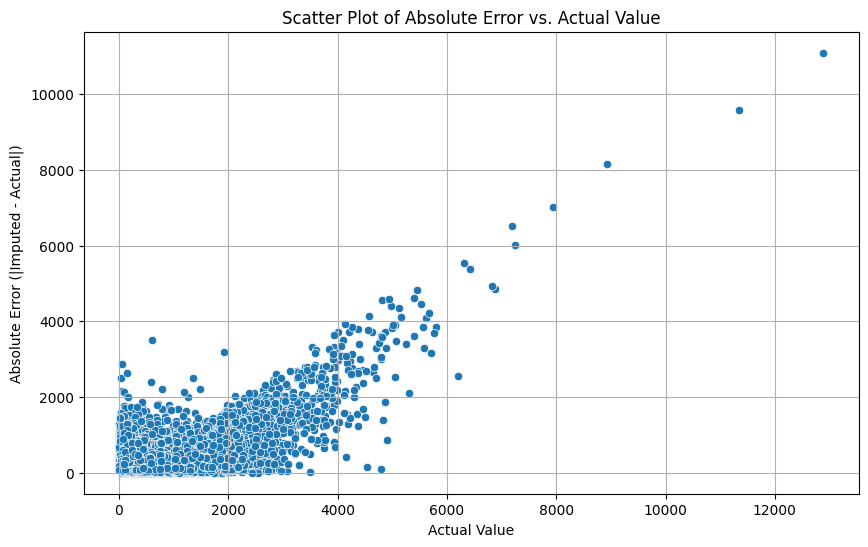

In [9]:
# Scatter plot showing how absolute error changes as actual value changes
plt.figure(figsize=(10, 6))
sns.scatterplot(x='actual_value', y='absolute_error', data=comparison_df)
plt.xlabel('Actual Value')
plt.ylabel('Absolute Error (|Imputed - Actual|)')
plt.title('Scatter Plot of Absolute Error vs. Actual Value')
plt.grid()
plt.show()

Find accounts with errors

In [10]:
# Identify accounts with the worst errors
worst_accounts = comparison_df.groupby('account')['error'].mean().sort_values(ascending=False).head(10)
print("Accounts with the worst average errors:")
display(worst_accounts)

Accounts with the worst average errors:


account
a04:512:8056F0549CBB3D26384A8AAE8F9484E2    2209.827241
a04:512:0E2FAC5E5DE8BDD92EEF38F75C897C50    1994.907202
b01:44132:957537723                         1789.732455
a04:512:898B72E0F29137D12DF506F1120FACB4    1786.944820
a04:512:4E51153FA81BEB0A17A9B72BF1A53569    1781.175093
a04:512:86009602D7B8118150764C2DABEB5FE8    1704.880251
a04:512:E3F232F4A6FC96E27D30972B46A91EDC    1686.660983
a04:512:BB937E4EE77596E35718595ED2344399    1673.692985
a04:512:17737BE2FFA89F5E8F8CE6B30FD9F113    1667.922533
a04:512:F73D5576144F42FEA1C80FEE4ED1011D    1639.578523
Name: error, dtype: float64

In [11]:
# Lastly apply imputation to whole dataset using KNN
knn_imputer = KNN()
imputed_data = knn_imputer.fit_transform(filtered_pivot_data)
imputed_data_df = pd.DataFrame(imputed_data, index=filtered_pivot_data.index, columns=filtered_pivot_data.columns)

Imputing row 1/6443 with 0 missing, elapsed time: 9.500
Imputing row 101/6443 with 3 missing, elapsed time: 9.508
Imputing row 201/6443 with 1 missing, elapsed time: 9.514
Imputing row 301/6443 with 3 missing, elapsed time: 9.519
Imputing row 401/6443 with 2 missing, elapsed time: 9.526
Imputing row 501/6443 with 2 missing, elapsed time: 9.531
Imputing row 601/6443 with 1 missing, elapsed time: 9.538
Imputing row 701/6443 with 5 missing, elapsed time: 9.544
Imputing row 801/6443 with 1 missing, elapsed time: 9.550
Imputing row 901/6443 with 2 missing, elapsed time: 9.556
Imputing row 1001/6443 with 1 missing, elapsed time: 9.563
Imputing row 1101/6443 with 0 missing, elapsed time: 9.570
Imputing row 1201/6443 with 1 missing, elapsed time: 9.577
Imputing row 1301/6443 with 0 missing, elapsed time: 9.585
Imputing row 1401/6443 with 2 missing, elapsed time: 9.592
Imputing row 1501/6443 with 3 missing, elapsed time: 9.598
Imputing row 1601/6443 with 1 missing, elapsed time: 9.605
Imputing 

# Part 2

import statements and cluster data

In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

# Prepare data for clustering
# Aggregate by account and merchant to get total spend by each user at each merchant
merchant_spend = data.groupby(['account', 'merchant'])['spend'].sum().unstack(fill_value=0)

# 1. Distance Metric 1: TF-IDF on merchants
merchant_strings = data.groupby('account')['merchant_string_example'].apply(lambda x: ' '.join(map(str, x))).reset_index()
tfidf = TfidfVectorizer()
tfidf_matrix = tfidf.fit_transform(merchant_strings['merchant_string_example'])
tfidf_similarity = cosine_similarity(tfidf_matrix)

# 2. Distance Metric 2: Euclidean distance on spending patterns across merchants
euclidean_distance = euclidean_distances(merchant_spend)

# 3. Clustering using KMeans on chosen metric (e.g., Euclidean distance)
kmeans = KMeans(n_clusters=15, random_state=42)
clusters = kmeans.fit_predict(euclidean_distance)

# Assign clusters to accounts and analyze top merchants per cluster
merchant_spend['cluster'] = clusters
top_merchants_per_cluster = merchant_spend.groupby('cluster').sum().apply(lambda x: x.nlargest(10).index.tolist(), axis=1)

# Count users per cluster
users_per_cluster = merchant_spend['cluster'].value_counts()

# Display the results
print("Top 10 Merchants per Cluster:")
print(top_merchants_per_cluster)
print("\nTotal Number of Users per Cluster:")
print(users_per_cluster)

Top 10 Merchants per Cluster:
cluster
0     [WALMART, AMAZON, 7-ELEVEN, MCDONALDS, UBER TE...
1     [7-ELEVEN, WALMART, PNC BANK, U.S. BANK, APPLE...
2     [7-ELEVEN, WALMART, U.S. BANK, PNC BANK, GOOGL...
3     [7-ELEVEN, WALMART, AMAZON, U.S. BANK, PNC BAN...
4     [WALMART, 7-ELEVEN, U.S. BANK, PNC BANK, APPLE...
5     [7-ELEVEN, WALMART, U.S. BANK, PNC BANK, AMAZO...
6     [WALMART, 7-ELEVEN, U.S. BANK, PNC BANK, USPS,...
7     [7-ELEVEN, WALMART, U.S. BANK, AMAZON, PNC BAN...
8     [WALMART, 7-ELEVEN, AMAZON, SQUARE, UBER TECHN...
9     [WALMART, AMAZON, ATT, 7-ELEVEN, MCDONALDS, DO...
10    [WALMART, AMAZON, 7-ELEVEN, ATT, KROGER, VERIZ...
11    [COINBASE, KROGER, COMCAST, JEWEL-OSCO, SPRINT...
12    [WALMART, U.S. BANK, 7-ELEVEN, GOOGLE, PNC BAN...
13    [WALMART, AMAZON, 7-ELEVEN, ATT, MCDONALDS, KR...
14    [WALMART, AMAZON, ATT, 7-ELEVEN, MCDONALDS, KR...
dtype: object

Total Number of Users per Cluster:
cluster
0     3011
8     1707
13    1102
3     1078
7      752
9      65

#### TF-IDF Similarity on Merchants
The TF-IDF metric highlights the frequency and uniqueness of merchant-related terms, emphasizing distinct shopping preferences. It identifies users' **unique loyalties** to niche or less popular merchants, making it valuable for profiling shoppers with specific tastes or brand affinities.

### Pros:
- Highlights unique or niche shopping patterns that may be valuable for personalized marketing.
- Insensitive to the absolute spend amount, focusing instead on shopping diversity.

### Cons:
- Ignores actual spend amounts, which may be more critical in financial analyses.
- Relies on text data, which may introduce biases if merchant descriptions are not standardized.

#### Euclidean Distance on Spending Patterns
Euclidean distance measures spending pattern similarities across merchants, capturing the quantitative distribution of expenditures. It reflects **spending habits and priorities**, clustering users with similar spending behaviors regardless of merchant differences.

### Pros:
- Focuses on spending amounts, making it highly relevant for financial segmentation and risk assessment.
- Captures a more direct, numerical representation of behavior.

### Cons:
- Does not account for merchant diversity or uniqueness; two users spending equally on entirely different merchants may still be considered similar.
- Sensitive to outliers, where exceptionally high spending at a few merchants can distort the distance.

Bar chart for the clusters

/var/folders/yk/ct2xq8td0470t3bypwg0z5fc0000gn/T/ipykernel_20021/1687446133.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=users_per_cluster.index, y=users_per_cluster.values, palette='viridis')


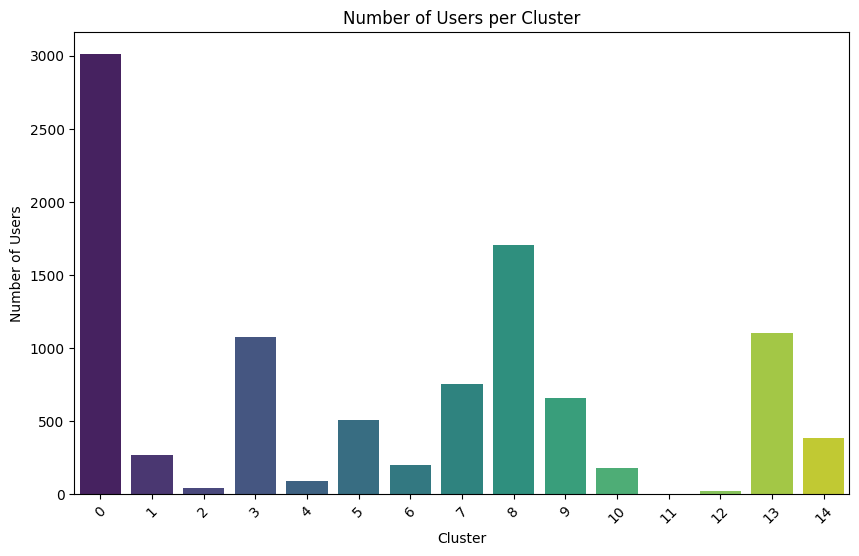

In [15]:
# 1. Bar Chart: Number of Users per Cluster
plt.figure(figsize=(10, 6))
sns.barplot(x=users_per_cluster.index, y=users_per_cluster.values, palette='viridis')
plt.xlabel('Cluster')
plt.ylabel('Number of Users')
plt.title('Number of Users per Cluster')
plt.xticks(rotation=45)
plt.show()

PCA visualization for clusters through scatter plot

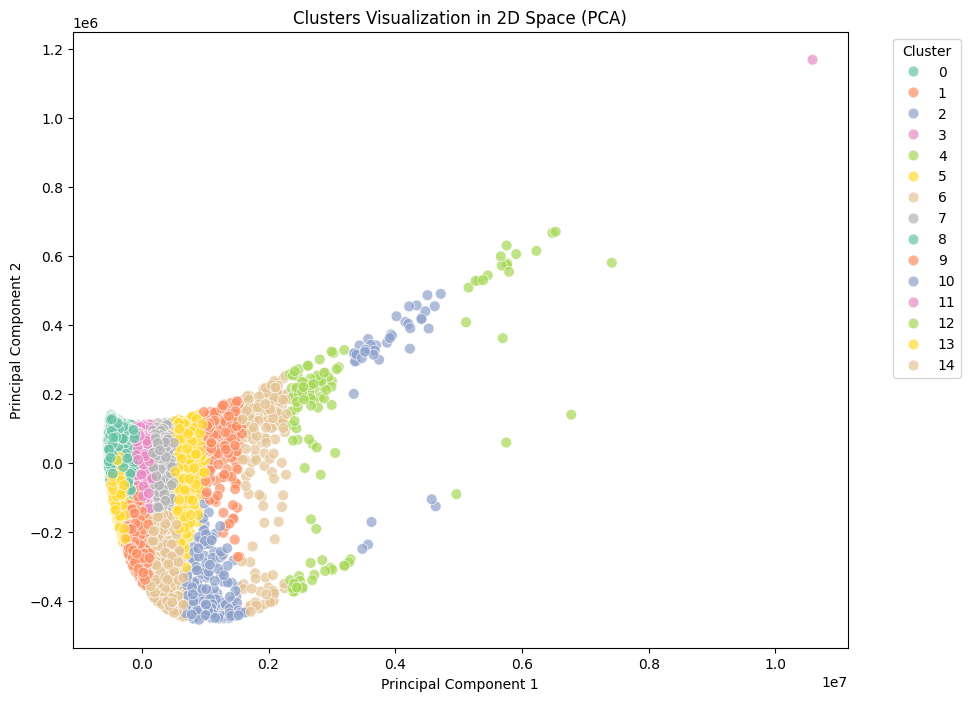

In [16]:
# 2. PCA for Visualization in 2D Space
# Reduce the dimensions of the spending patterns for visualization
pca = PCA(n_components=2)
principal_components = pca.fit_transform(euclidean_distance)
pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
pca_df['Cluster'] = clusters

# Scatter plot to visualize clusters
plt.figure(figsize=(10, 8))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='Cluster', palette='Set2', s=60, alpha=0.7)
plt.title('Clusters Visualization in 2D Space (PCA)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()